## Лабораторная работа 3

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.cuda.is_available()

False

In [3]:
activation_function = nn.Tanh()
def myfun(x):
    return np.sin(x / 2)

In [4]:
def approx_1d_function(x_train, x_eval, units, epochs):
    #Создание меток обучающих данных
    y_train = myfun(x_train)
    #Нормализация данных
    x_scaler = MinMaxScaler(feature_range=((-1,1)))
    y_scaler = MinMaxScaler(feature_range=((-1,1)))
                            
    x_scaled = x_scaler.fit_transform(x_train)
    y_scaled = y_scaler.fit_transform(y_train)                            
    x_eval_scaled = x_scaler.transform(x_eval)
    
                            
    #Создание модели машинного обучения                  
    _, result_eval = train_model_simple(x_scaled, y_scaled, x_eval_scaled, units, epochs)
    
                            
                            
    #Возврат к исходному диапазону
    res_rescaled = y_scaler.inverse_transform(result_eval)
    
    #Расчет меток
    y_eval = myfun(x_eval)
    return x_eval, res_rescaled, y_eval
                            
                            

In [5]:
def train_model_simple(x_train, y_train, x_eval, units, epochs):
    x_train_tensor = torch.from_numpy(x_train).float().to(device)
    x_eval_tensor = torch.from_numpy(x_eval).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).float().to(device)
    # предопределенные линейные слои, параметрами являются входные и выходные нейроны
    layer1 = nn.Linear(x_train.shape[1], units).to(device)
    layer2 = nn.Linear(units, units)
    layer3 = nn.Linear(units, 1).to(device)
    
    #сбор параметров для обоих слоев
    parameters = list(layer1.parameters()) + list(layer2.parameters()) + list(layer3.parameters())
    
    #Оптимизатор адам и среднеквадратичная ошибка потерь
    optimizer = optim.Adam(parameters)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # главный цикл
    for epoch in range(epochs):
        yhat = layer3(activation_function(layer2(activation_function(layer1(x_train_tensor)))))

        loss = loss_fn(yhat, y_train_tensor)

        #вычисление градиентов
        loss.backward()

        #выполнение шага оптимизации
        optimizer.step()
        
        #остальные градиенты до нуля
        optimizer.zero_grad()
        
    yhat_eval = layer3(activation_function(layer2(activation_function(layer1(x_eval_tensor)))))
    
    return yhat.detach().cpu().numpy(), yhat_eval.detach().cpu().numpy()

In [6]:
def plot_1d_function(x_train, x_eval, predictions, labels, units, epochs):
    fig = plt.figure(1, figsize=(18,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
    plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
    plt.plot(x_train, myfun(x_train), '.', color='royalblue')
    plt.grid(which='both')
    plt.rcParams.update({'font.size':14})
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('%d neurons in hidden layer with %d epochs of training' % (units, epochs))
    plt.legend(['Function f(x)', 'MLP output g(x)', 'Training set'])
    ax = fig.add_subplot(1, 2, 2)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, np.abs(predictions-myfun(x_eval)), '-', label='output', color='firebrick', linewidth=2.0)
    plt.grid(which='both')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Absolute difference between prefiction and actual function')
    plt.legend(['Error |f(x)-g(x)|'])
    plt.show()

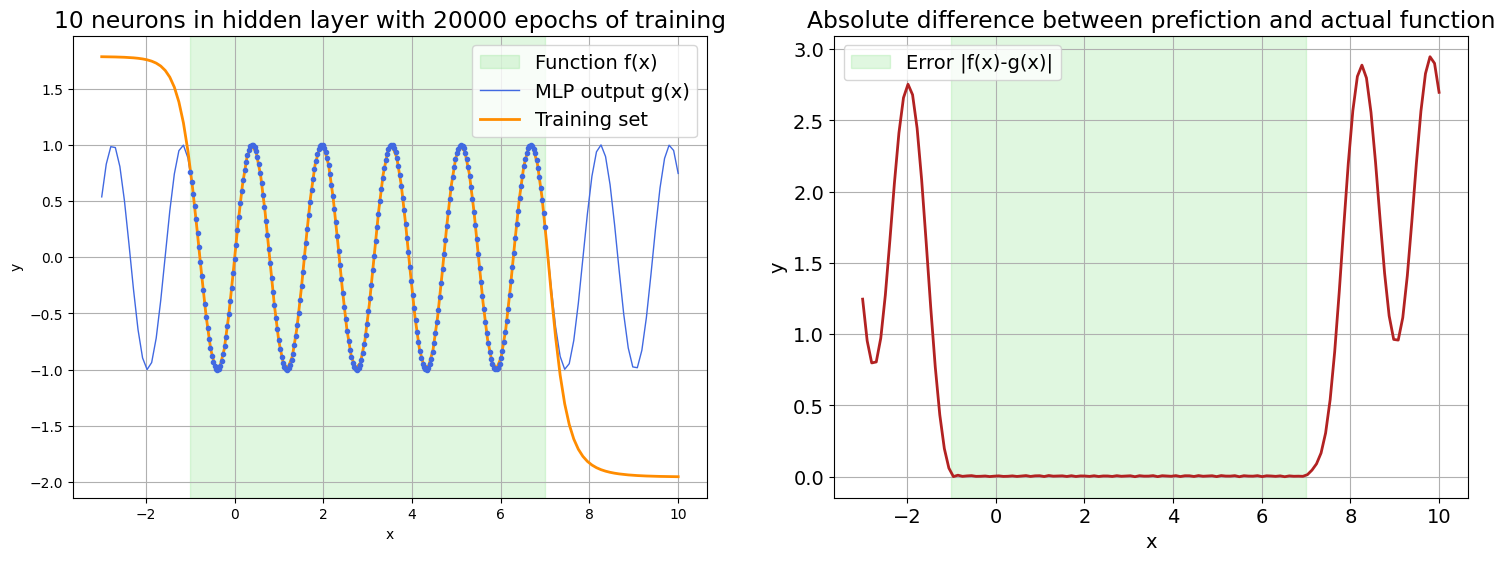

In [7]:
batch_size_train = 250
batch_size_eval = 128

#Генерация тренировочных данных
x_train_fix = np.linspace(-1, 7, num=batch_size_train).reshape(-1,1)

#Генерация оценочных данных
x_eval_fix = np.linspace(-3, 10, num=batch_size_eval).reshape(-1,1)

units = 10
epochs = 20000

x, predictions, labels = approx_1d_function(x_train=x_train_fix, x_eval=x_eval_fix, units=units, epochs=epochs)
plot_1d_function(x_train_fix, x_eval_fix, predictions, labels, units, epochs)